In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from jaxgym.run import solve_model
import jaxgym.components as comp
from optax import apply_updates
from jaxgym.ray import Ray
import tqdm.auto as tqdm
import json
%matplotlib widget
jax.config.update('jax_platform_name', 'cpu')

This notebook demonstrates how an optimiser in jax can be used to find which rays from the detector that will converge on a point source in the fourdstem model. 

Loss Function for later

In [2]:
@jax.jit
def loss(tilts, det_coords, inv_matrix, scan_pos):
    n_rays = det_coords.shape[0]

    det_coords_x, det_coords_y = det_coords[:, 0], det_coords[:, 1]
    tilts_x, tilts_y = tilts[:, 0], tilts[:, 1]

    rays_at_det = jnp.array([det_coords_x, 
                             det_coords_y,
                             tilts_x,
                             tilts_y,
                             jnp.ones(n_rays)])
    
    rays_at_pt_source = jnp.matmul(inv_matrix, rays_at_det).T

    rays_pt_source_x = rays_at_pt_source[:, 0]
    rays_pt_source_y = rays_at_pt_source[:, 1]

    start_position = jnp.array([rays_pt_source_x, rays_pt_source_y])   

    error = jnp.linalg.norm(start_position - scan_pos) 

    return error

Load dataset and parameters

In [3]:
fourdstem_array = np.load('fourdstem_array.npy')
params_dict = json.load(open('params.json'))

semi_conv = params_dict['semi_conv']
defocus = params_dict['defocus']
camera_length = params_dict['camera_length']
scan_shape = params_dict['scan_shape']
det_shape = params_dict['det_shape']
scan_step = params_dict['scan_step']
det_px_size = params_dict['det_px_size']
scan_rotation = params_dict['scan_rotation']
descan_error = params_dict['descan_error']

Create the model

In [4]:
#Create ray input z plane
crossover_z = jnp.zeros((1))

PointSource = comp.PointSource(z=crossover_z, semi_conv=semi_conv)
ScanGrid = comp.ScanGrid(z=jnp.array([params_dict['defocus']]), 
                         scan_step=params_dict['scan_step'], 
                         scan_shape=params_dict['scan_shape'], 
                         scan_rotation=params_dict['scan_rotation'])

scan_coords = ScanGrid.coords
scan_y, scan_x = scan_coords[0, 0], scan_coords[0, 1]

Descanner = comp.Descanner(z=jnp.array([params_dict['defocus']]), 
                           descan_error=params_dict['descan_error'], 
                           offset_x=scan_x, 
                           offset_y=scan_y)

Detector = comp.Detector(z=jnp.array([params_dict['camera_length']]), 
                         det_shape=params_dict['det_shape'], 
                         det_pixel_size=params_dict['det_px_size'])

model = [PointSource, ScanGrid, Descanner, Detector]

Find the transfer matrices in the model: Note here only one ray and it's gradients are used to find the ray transfer matrices! See solve_model for the clear explanation

Although the component step functions can be used to just propagate rays normally, we never really need it if we can always find the coefficients of the system, and 
use either linear matrices or polynomials to go forward or backwards in the model. 

In [5]:
# Prepare input ray position for this scan point.
input_ray_positions = jnp.array([scan_x, scan_y, 0.0, 0.0, 1.0])

ray = Ray(
    z=PointSource.z,
    matrix=input_ray_positions,
    pathlength=jnp.zeros(1),
)

'''THIS FUNCTION IS THE KEY PART of JaxGym, where the central differences between TemGym and TorchGym are clear; 
In it, we find the ray transfer matrices via a single ray and it's gradients that are propagated through the model.
Effectively "solving" the optical model numerically.'''
transfer_matrices = solve_model(ray, model)

# Initialise the total_transfer_matrix
# as the last transfer matrix in the list,
# and multiply it with the previous transfer matrices
# in reverse order to get the total transfer matrix
# for the whole model.
total_transfer_matrix = transfer_matrices[-1]
for tm in reversed(transfer_matrices[:-1]):
    total_transfer_matrix = total_transfer_matrix @ tm

# Get the transfer matrix to go backwards. 
detector_to_point_source_matrix = jnp.linalg.inv(total_transfer_matrix)

Run the optimisation routine to go back to a pt source: I've tried all the optimisers in optax and a selection of learning rates, the 2 optimizers that worked best I have kept below. 

sgd:   0%|          | 0/1000 [00:00<?, ?it/s]

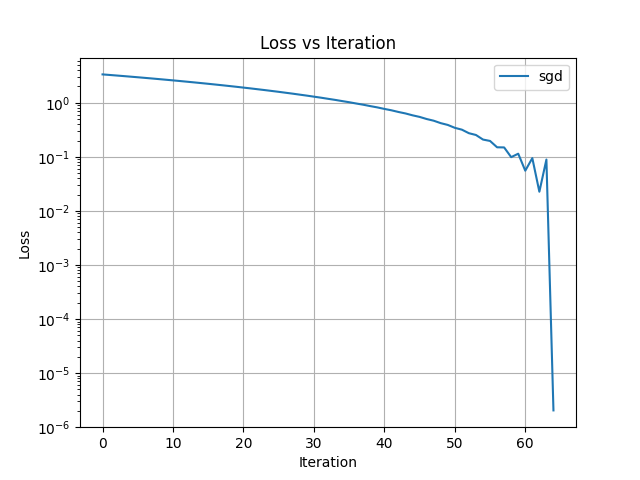

In [9]:
import optax

det_coords = Detector.get_coords()
tilts = jnp.zeros((det_coords.shape[0], 2))
scan_pos = jnp.array([[scan_x, scan_y]]).T

optimizer_dict = {
    "sgd": optax.sign_sgd(learning_rate=1e-3),
}

results = {}
max_iterations = 1000
loss_val = 1.0
for opt_name, opt in optimizer_dict.items():
    cur_tilts = jnp.zeros((det_coords.shape[0], 2))
    opt_state = opt.init(cur_tilts)
    loss_history = []
    
    for i in tqdm.trange(max_iterations, desc=opt_name):

        loss_val, grads = jax.value_and_grad(loss, argnums=0)(
            cur_tilts, det_coords, detector_to_point_source_matrix, scan_pos
        )
        loss_history.append(loss_val)

        if loss_val < 1e-5:
            break

        updates, opt_state = opt.update(grads, opt_state)
        cur_tilts = apply_updates(cur_tilts, updates)

    results[opt_name] = loss_history


plt.figure()
for opt_name, history in results.items():
    plt.plot(history, label=opt_name)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss vs Iteration')
plt.legend()
plt.grid(True)
plt.show()


Get the rays at the point source for plotting

In [10]:
n_rays = det_coords.shape[0]
det_coords_x, det_coords_y = det_coords[:, 0], det_coords[:, 1]

rays_det_matrix = jnp.array([det_coords_x, 
                             det_coords_y,
                             cur_tilts[:, 0],
                             cur_tilts[:, 1],
                             jnp.ones(n_rays)])

rays_pt_source = jnp.matmul(detector_to_point_source_matrix, rays_det_matrix).T

rays_pt_source_x = rays_pt_source[:, 0]
rays_pt_source_y = rays_pt_source[:, 1]

loss(cur_tilts, det_coords, detector_to_point_source_matrix, scan_pos)

Array(2.0444888e-06, dtype=float32)

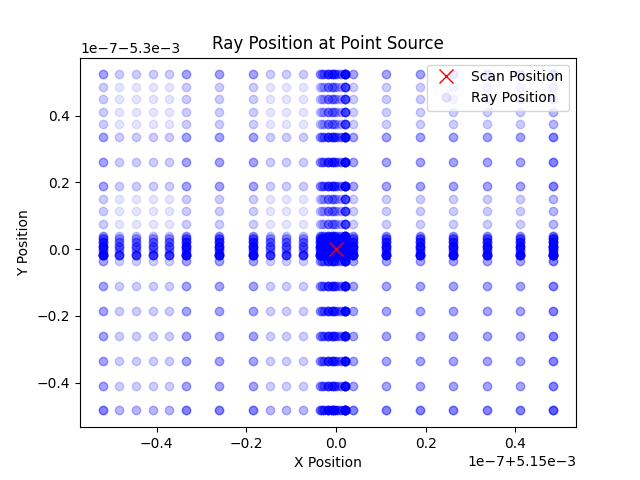

In [11]:
plt.figure()
plt.plot(scan_pos[0], scan_pos[1], 'rx', label='Scan Position', markersize=10, zorder=10)
plt.plot(rays_pt_source_x, rays_pt_source_y, 'bo', label='Ray Position', alpha=0.1)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Ray Position at Point Source')
plt.legend()

Some thoughts: This is to find one scan_position, and seems to converge fast with sign_sgd as an optimiser, but I am not sure about doing this for every pixel in the detector, although it is still possible. I think though one issue is the optimiser is very sensitive to the step-size. So for each time the model parameters change, the step_size would need to be adjusted. Unless one can normalise everything to be between 0 and 1 somehow, and standardise the units so one step-size can be optimised for any model. 